<a href="https://colab.research.google.com/github/doowilliams/transfer-learning-on-image-food-classification/blob/main/06_tranfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 3: Scaling up (Food Vision mini)

We've the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of th eclasses in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning)

## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/doowilliams/data_science_portfolio/main/functions/williams_help_functions.py


--2023-04-22 18:45:54--  https://raw.githubusercontent.com/doowilliams/data_science_portfolio/main/functions/williams_help_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10317 (10K) [text/plain]
Saving to: ‘williams_help_functions.py’

williams_help_funct 100%[===================>]  10.08K  --.-KB/s    in 0s      

2023-04-22 18:45:55 (106 MB/s) - ‘williams_help_functions.py’ saved [10317/10317]



In [ ]:
# Import series of the helper function for our notebook
from williams_help_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

our goal is to best the oringinal Food101 paper with 10% of the training data, so let's download it.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-04-22 18:46:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  19.5MB/s    in 69s     

2023-04-22 18:47:11 (22.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caesar_salad'.
There are 0 directories and 75 images

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)# don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential, Model

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to bwtween 0 & 1, required for model likes RestNet50
], name='data_augmentation')

In [ ]:
from keras.layers.serialization import activation
# Setup the base model and freeze its layers (this will extract featuers)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in iinference mode so weights which need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15%
                                            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 112s 410ms/step - loss: 3.3759 - accuracy: 0.2681 - val_loss: 2.5990 - val_accuracy: 0.4163
Epoch 2/5
237/237 [==============================] - 76s 319ms/step - loss: 2.1986 - accuracy: 0.4961 - val_loss: 2.1442 - val_accuracy: 0.4809
Epoch 3/5
237/237 [==============================] - 76s 318ms/step - loss: 1.8235 - accuracy: 0.5686 - val_loss: 1.9701 - val_accuracy: 0.5037
Epoch 4/5
237/237 [==============================] - 68s 287ms/step - loss: 1.6032 - accuracy: 0.6150 - val_loss: 1.8551 - val_accuracy: 0.5281
Epoch 5/5
237/237 [==============================] - 71s 295ms/step - loss: 1.4352 - accuracy: 0.6481 - val_loss: 1.8190 - val_accuracy: 0.5318


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 69s 88ms/step - loss: 1.5830 - accuracy: 0.5834


[1.5830309391021729, 0.5834455490112305]

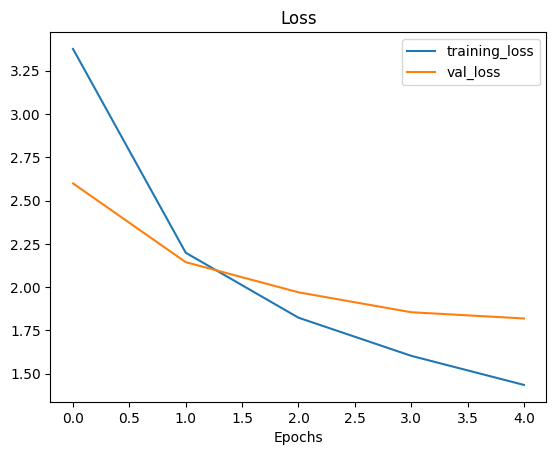

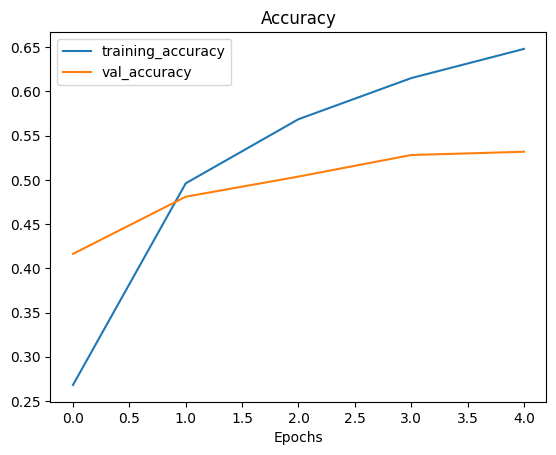

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

❓**Question** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

### Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
#from keras.optimizers.optimizer_experimental import optimizer
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),# learning rate lowerd by 10X
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)


input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable inour base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 (feature extraction), this is the total number of epochs we're aftyer (5 + 5 = 10)

# Fite-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 76s 278ms/step - loss: 1.4896 - accuracy: 0.6041 - val_loss: 1.8872 - val_accuracy: 0.5042
Epoch 6/10
237/237 [==============================] - 65s 268ms/step - loss: 1.0873 - accuracy: 0.6970 - val_loss: 1.8107 - val_accuracy: 0.5252
Epoch 7/10
237/237 [==============================] - 62s 262ms/step - loss: 0.8238 - accuracy: 0.7665 - val_loss: 1.9035 - val_accuracy: 0.5350
Epoch 8/10
237/237 [==============================] - 64s 267ms/step - loss: 0.6608 - accuracy: 0.8165 - val_loss: 2.1280 - val_accuracy: 0.4899
Epoch 9/10
237/237 [==============================] - 63s 263ms/step - loss: 0.5238 - accuracy: 0.8457 - val_loss: 2.3649 - val_accuracy: 0.4719
Epoch 10/10
237/237 [==============================] - 52s 216ms/step - loss: 0.4124 - accuracy: 0.8778 - val_loss: 2.3652 - val_accuracy: 0.4751


In [ ]:
# Evalute on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 88s 112ms/step - loss: 1.8866 - accuracy: 0.5726


[1.8866240978240967, 0.5725544691085815]

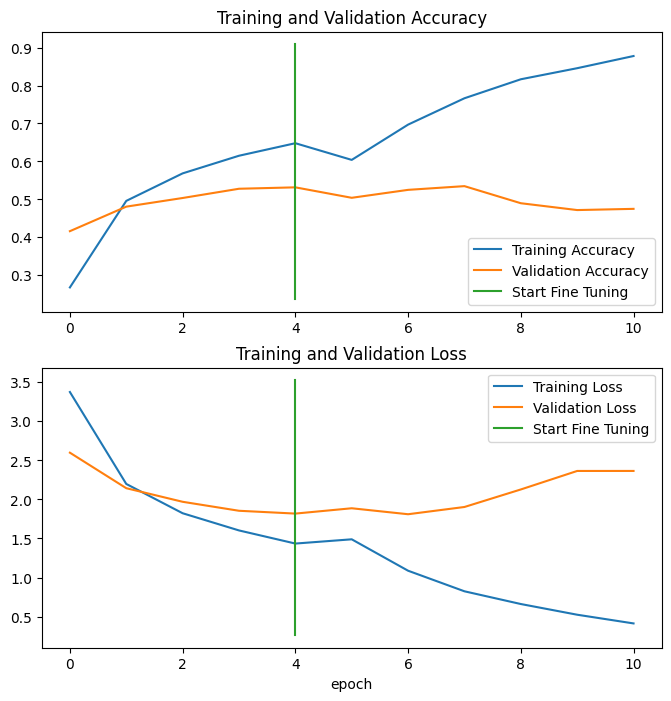

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(history_all_classes_10_percent,
                 history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
# Save our fine-tuning  model
#model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
#loaded_model_results = loaded_model.evaluate(test_data)
#loaded_model_results

## Evaluating the performace of the model across all different classes

lst's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)


--2023-04-22 19:05:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  13.9MB/s    in 4.0s    

2023-04-22 19:05:09 (11.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/101_food_classes_10_percent.zip")

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 81s 103ms/step - loss: 1.8866 - accuracy: 0.5726


(1.8866240978240967, 0.5725544691085815)

## Making prediction with ourtrained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)# set verboisty to see how long is left

790/790 [==============================] - 66s 81ms/step


In [ ]:
# how many prediction are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# let's see what the first 10 predictions look like
preds_probs[:10]

array([[4.7026083e-02, 7.2416964e-07, 7.1465868e-01, ..., 5.0743955e-07,
        1.0216702e-03, 7.1724984e-03],
       [9.5489335e-01, 1.5540050e-09, 3.0012298e-04, ..., 1.1744738e-03,
        4.7135766e-09, 3.6278755e-07],
       [1.1356066e-01, 3.6770308e-03, 3.0362712e-02, ..., 8.4938954e-05,
        5.8757636e-04, 7.8545501e-03],
       ...,
       [3.7818053e-03, 5.9078671e-09, 3.7484817e-05, ..., 1.5603998e-01,
        1.8685679e-07, 3.5793369e-07],
       [2.9087529e-01, 2.1163542e-05, 2.2192836e-01, ..., 2.0380691e-03,
        8.5111373e-05, 1.3361237e-03],
       [3.1506446e-01, 4.7844654e-08, 8.7618224e-05, ..., 7.6889736e-04,
        2.4416474e-07, 1.6455648e-04]], dtype=float32)

In [ ]:
# What does the first prediction probability array look likes?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([4.70260829e-02, 7.24169638e-07, 7.14658678e-01, 1.10110445e-08,
        3.18255957e-06, 3.61868366e-08, 1.55885289e-06, 6.92487561e-08,
        3.42184649e-04, 6.25744633e-06, 5.89065579e-08, 1.65872464e-07,
        5.54398002e-06, 4.86972862e-09, 3.39648868e-05, 5.02068317e-04,
        5.54796543e-07, 8.53144593e-05, 5.93301235e-03, 1.98638887e-07,
        1.07098708e-03, 1.23283201e-06, 2.54522718e-04, 5.82027060e-05,
        6.20677648e-03, 1.20719464e-03, 3.30775132e-04, 2.30672845e-06,
        1.42468617e-03, 2.36912048e-04, 7.38918615e-08, 1.61781174e-03,
        1.19595163e-04, 3.82228308e-07, 5.57640381e-03, 1.04398441e-06,
        3.38337230e-07, 3.38118261e-05, 1.16559109e-04, 7.98660676e-06,
        5.24994430e-05, 1.48235785e-03, 6.06728554e-06, 1.08376810e-06,
        2.72211837e-05, 1.73633562e-05, 1.28208124e-03, 3.24711937e-06,
        4.05195493e-07, 3.27559537e-03, 4.58632212e-06, 3.10838077e-05,
        1.99400503e-02, 7.60443683e-04, 2.48840061e-05, 5.886368

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What predicition probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probabilitry by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What predicition probability sample 0 looks like:
 [4.70260829e-02 7.24169638e-07 7.14658678e-01 1.10110445e-08
 3.18255957e-06 3.61868366e-08 1.55885289e-06 6.92487561e-08
 3.42184649e-04 6.25744633e-06 5.89065579e-08 1.65872464e-07
 5.54398002e-06 4.86972862e-09 3.39648868e-05 5.02068317e-04
 5.54796543e-07 8.53144593e-05 5.93301235e-03 1.98638887e-07
 1.07098708e-03 1.23283201e-06 2.54522718e-04 5.82027060e-05
 6.20677648e-03 1.20719464e-03 3.30775132e-04 2.30672845e-06
 1.42468617e-03 2.36912048e-04 7.38918615e-08 1.61781174e-03
 1.19595163e-04 3.82228308e-07 5.57640381e-03 1.04398441e-06
 3.38337230e-07 3.38118261e-05 1.16559109e-04 7.98660676e-06
 5.24994430e-05 1.48235785e-03 6.06728554e-06 1.08376810e-06
 2.72211837e-05 1.73633562e-05 1.28208124e-03 3.24711937e-06
 4.05195493e-07 3.27559537e-03 4.58632212e-06 3.10838077e-05
 1.99400503e-02 7.60443683e-04 2.48840061e-05 5.88636867e-05
 1.68610155e-03 2.64916773e-04 8.74673773e

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look
pred_classes[:10]



array([ 2,  0,  0,  8,  2, 62, 29, 62,  0, 41])

In [ ]:
# How many pred classes do we have
len(pred_classes)

25250

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, ....0, 0], we want the index value where the "1" occurs
y_labels[:10] # looks at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions
one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
loaded_loss, loaded_accuracy

(1.8866240978240967, 0.5725544691085815)

In [ ]:
# let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5725544554455445

## let's get visual: making a confusion matrix

In [ ]:
from williams_help_functions import make_confusion_matrix

In [ ]:
# get a list of class names
class_names = test_data.class_names

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix funcation to ensure the x-labels print verically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(150, 150), text_size=30,savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class(e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.26      0.29       250
           1       0.84      0.51      0.64       250
           2       0.67      0.62      0.64       250
           3       0.76      0.45      0.57       250
           4       0.39      0.55      0.46       250
           5       0.54      0.38      0.44       250
           6       0.65      0.78      0.71       250
           7       0.97      0.60      0.74       250
           8       0.39      0.42      0.40       250
           9       0.67      0.35      0.46       250
          10       0.51      0.42      0.46       250
          11       0.89      0.44      0.58       250
          12       0.88      0.46      0.60       250
          13       0.66      0.54      0.59       250
          14       0.79      0.38      0.51       250
          15       0.33      0.37      0.35       250
          16       0.70      0.59      0.64       250
          17       0.37    

The numbers above give a graet class-by-class evaluation of our model's predictions but with so classes, they're quite hard to understand.

How about we create a visualization to get a better understanding

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3333333333333333,
  'recall': 0.256,
  'f1-score': 0.2895927601809955,
  'support': 250},
 '1': {'precision': 0.8421052631578947,
  'recall': 0.512,
  'f1-score': 0.6368159203980099,
  'support': 250},
 '2': {'precision': 0.670995670995671,
  'recall': 0.62,
  'f1-score': 0.6444906444906445,
  'support': 250},
 '3': {'precision': 0.7635135135135135,
  'recall': 0.452,
  'f1-score': 0.5678391959798995,
  'support': 250},
 '4': {'precision': 0.38920454545454547,
  'recall': 0.548,
  'f1-score': 0.4551495016611296,
  'support': 250},
 '5': {'precision': 0.536723163841808,
  'recall': 0.38,
  'f1-score': 0.4449648711943794,
  'support': 250},
 '6': {'precision': 0.6533333333333333,
  'recall': 0.784,
  'f1-score': 0.7127272727272727,
  'support': 250},
 '7': {'precision': 0.9675324675324676,
  'recall': 0.596,
  'f1-score': 0.7376237623762376,
  'support': 250},
 '8': {'precision': 0.39097744360902253,
  'recall': 0.416,
  'f1-score': 0.40310077519379844,
  'support':

Let's plot of our classes F1-scores

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":# stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictinary
    class_f1_scores[class_names[int(k)]] = v["f1-score"] # is the same as classification_report_dict["99"]["f1-score"]
class_f1_scores

{'apple_pie': 0.2895927601809955,
 'baby_back_ribs': 0.6368159203980099,
 'baklava': 0.6444906444906445,
 'beef_carpaccio': 0.5678391959798995,
 'beef_tartare': 0.4551495016611296,
 'beet_salad': 0.4449648711943794,
 'beignets': 0.7127272727272727,
 'bibimbap': 0.7376237623762376,
 'bread_pudding': 0.40310077519379844,
 'breakfast_burrito': 0.4619422572178477,
 'bruschetta': 0.4625550660792952,
 'caesar_salad': 0.5844504021447721,
 'cannoli': 0.6036745406824148,
 'caprese_salad': 0.5916114790286976,
 'carrot_cake': 0.5121293800539084,
 'ceviche': 0.3465160075329567,
 'cheese_plate': 0.6405228758169934,
 'cheesecake': 0.4328859060402685,
 'chicken_curry': 0.5075921908893709,
 'chicken_quesadilla': 0.5751295336787565,
 'chicken_wings': 0.687603305785124,
 'chocolate_cake': 0.5019762845849802,
 'chocolate_mousse': 0.3045267489711934,
 'churros': 0.7333333333333334,
 'clam_chowder': 0.6448362720403022,
 'club_sandwich': 0.6476868327402137,
 'crab_cakes': 0.3920145190562613,
 'creme_brulee'

In [ ]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_names  f1-score
33           edamame  0.960784
63          macarons  0.876033
32         dumplings  0.855319
86           sashimi  0.841046
65           mussels  0.824701
..               ...       ...
99      tuna_tartare  0.309735
22  chocolate_mousse  0.304527
0          apple_pie  0.289593
93             steak  0.267806
77         pork_chop  0.218085

[101 rows x 2 columns]

In [ ]:
# What does our dataframe look like?
f1_scores[:10]

class_names  f1-score
33        edamame  0.960784
63       macarons  0.876033
32      dumplings  0.855319
86        sashimi  0.841046
65        mussels  0.824701
45  frozen_yogurt  0.823779
64      miso_soup  0.817164
69        oysters  0.811700
76          pizza  0.806630
68    onion_rings  0.803883

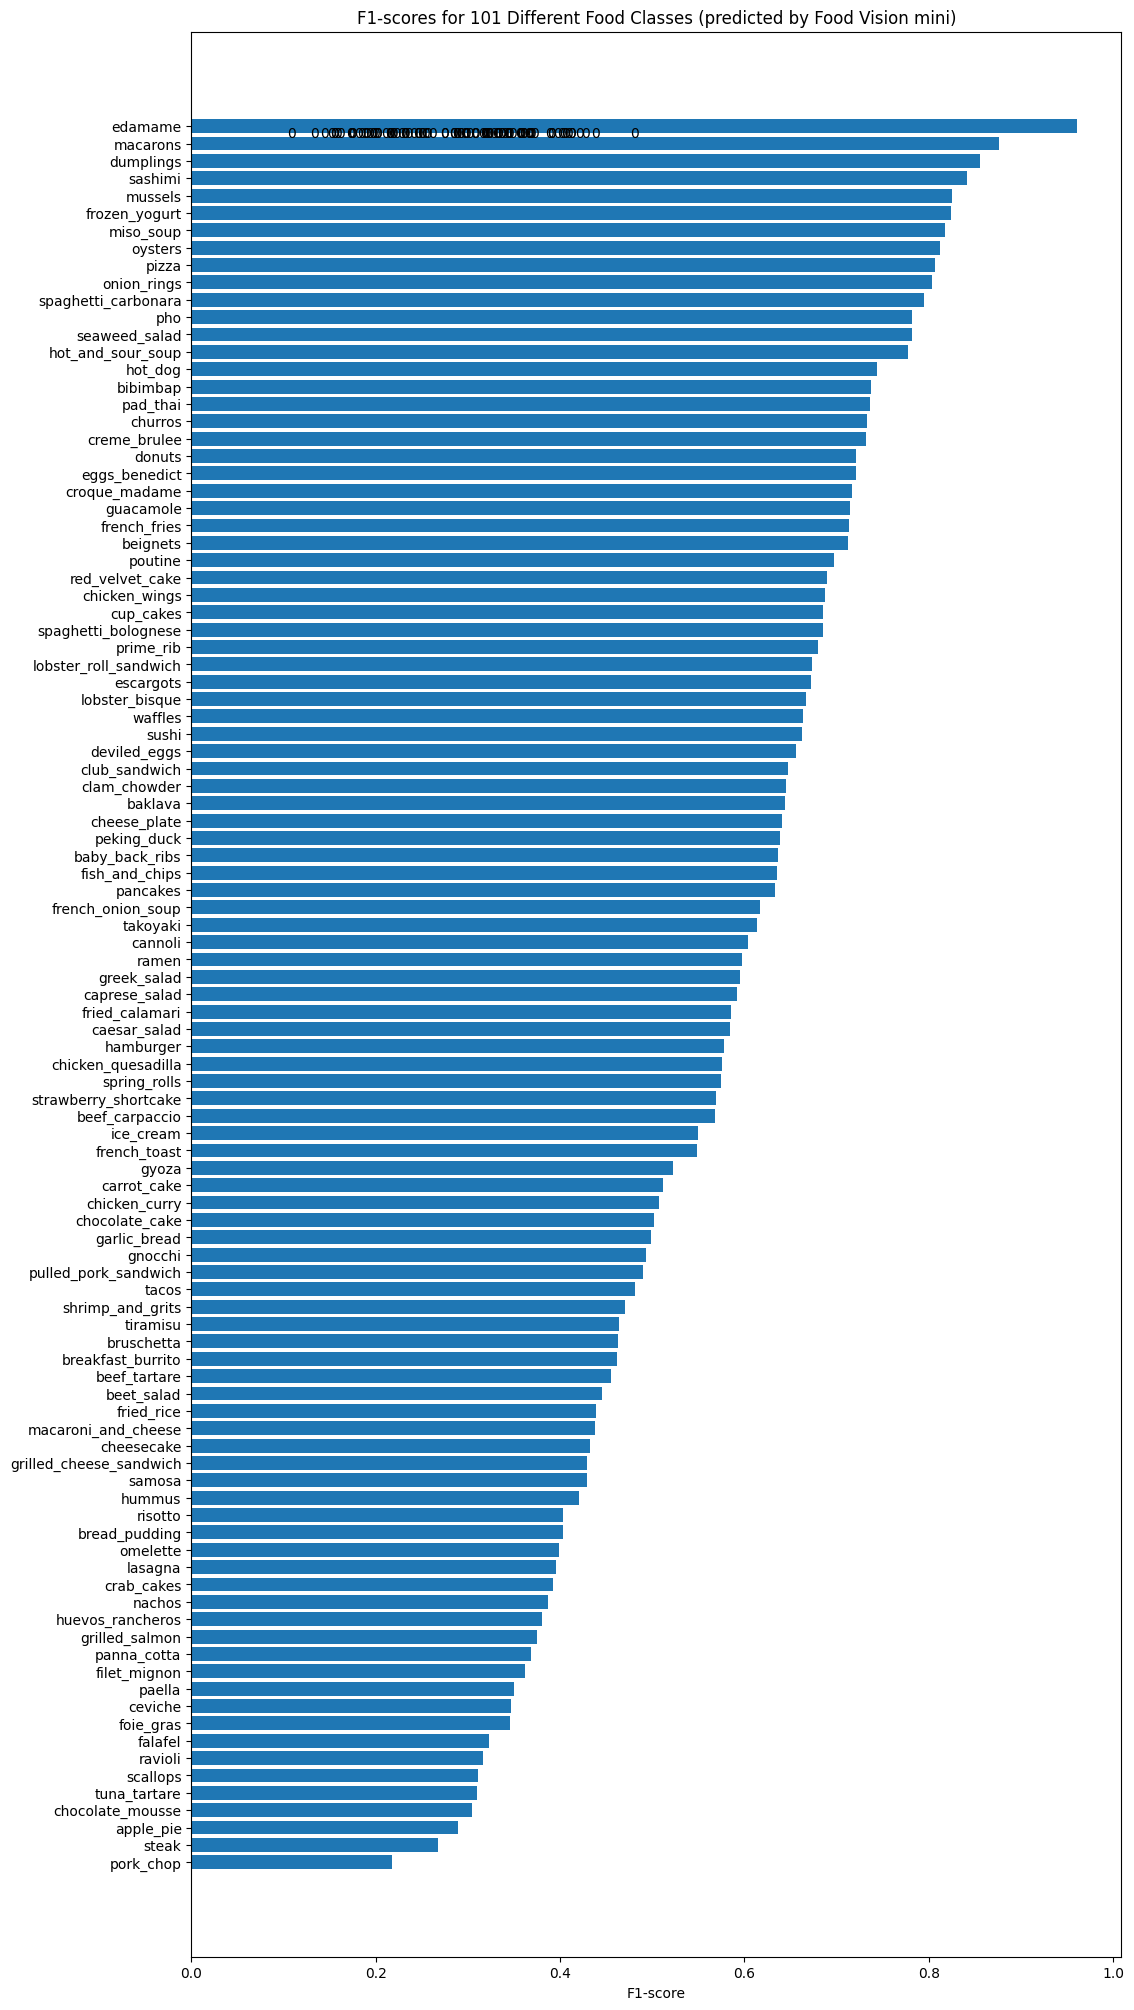

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height
  """
  for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')

autolabel(scores)
plt.show()

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to loed and preprocess images, spcifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1(if necessary)


In [ ]:
import tensorflow as tf

def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    specified shape (img_shape, img_shape, color_channels=3).

    Args:
      filename (str): path to target image
      img_shape (int): height/width dimension of target image size
      scale (bool): scale pixel values from 0-255 to 0-1 or not
    """
    # Read in the image
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale? Yes/no
    if scale:
        # rescale the image (get all value between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale images for EfficientNet models in TensorFlow


Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make preredictions on the loaded images
3. plot the original images(s) aling with the model's predictions, prediction probability and truth label

1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


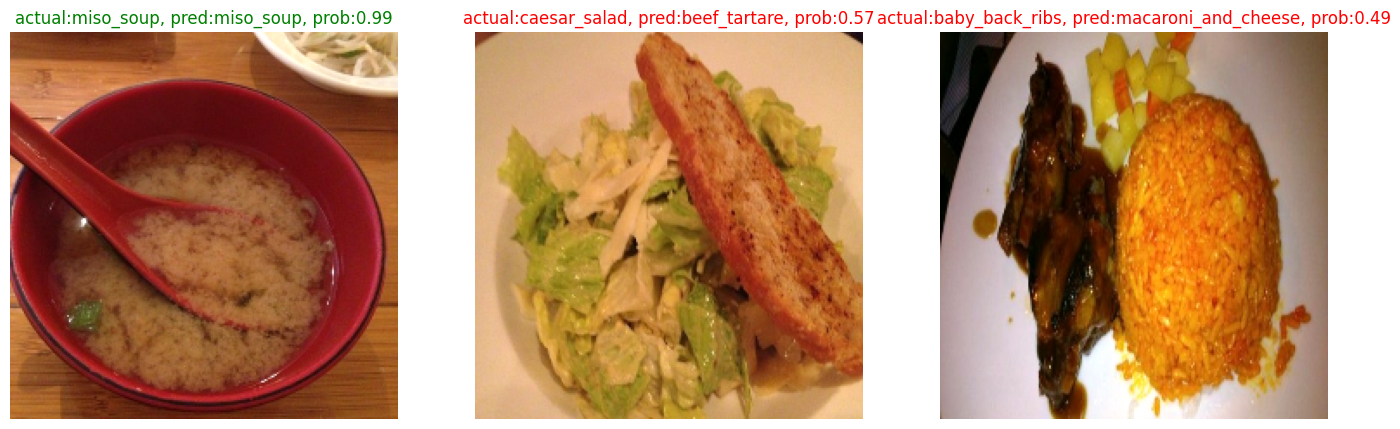

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  #print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
  #print(pred_prob)
  #print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/225)
  if class_name == pred_class:# if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual:{class_name}, pred:{pred_class}, prob:{pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


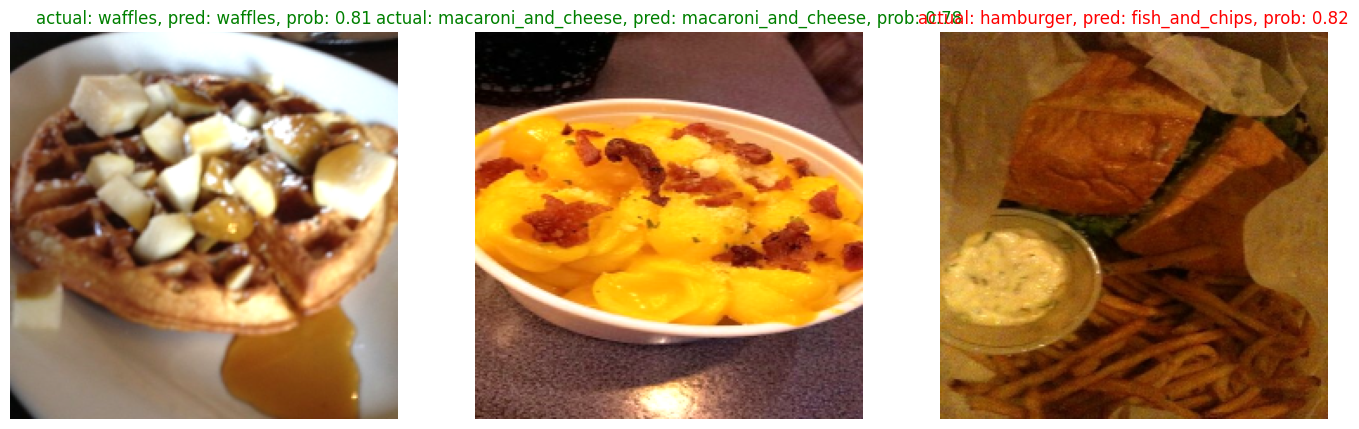

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))


for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded)[0]
    pred_class = class_names[pred_prob.argmax()]

    # Plot the image
    plt.subplot(1, 3, i+1)
    plt.imshow(img/225)
    plt.axis(False)

    # Check if predicted class matches true class
    if class_name == pred_class:
        title_color = "g" # green text if predicted class matches true class
    else:
        title_color = "r" # red text if predicted class doesn't match true class

    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)


## Finding the most wrong prediction

To find out where our model is most wrong, let's write some code to find out the following:
1. get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (were the ground truth label doesn't match the prediction).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# Get all of the image file paths in the test dataset
filepaths = []
for fillepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                      shuffle=False):
  filepaths.append(filepath)
filepaths[:10]

['101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg',
 '101_food_classes_10_percent/test/hamburger/85915.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      101_food_classes_10_percent/test/hamburger/859...       0       2   
1      101_food_classes_10_percent/test/hamburger/859...       0       0   
2      101_food_classes_10_percent/test/hamburger/859...       0       0   
3      101_food_classes_10_percent/test/hamburger/859...       0       8   
4      101_food_classes_10_percent/test/hamburger/859...       0       2   
...                                                  ...     ...     ...   
25245  101_food_classes_10_percent/test/hamburger/859...     100     100   
25246  101_food_classes_10_percent/test/hamburger/859...     100      16   
25247  101_food_classes_10_percent/test/hamburger/859...     100     100   
25248  101_food_classes_10_percent/test/hamburger/859...     100      94   
25249  101_food_classes_10_percent/test/hamburger/859...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.714659        apple_pie               baklava  
1       0.954893        apple_pie             apple_pie  
2       0.113561        apple_pie             apple_pie  
3       0.359555        apple_pie         bread_pudding  
4       0.436267        apple_pie               baklava  
...          ...              ...                   ...  
25245   0.999815          waffles               waffles  
25246   0.936055          waffles          cheese_plate  
25247   0.677594          waffles               waffles  
25248   0.634534          waffles  strawberry_shortcake  
25249   0.886719          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out DataFrame Wich predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  101_food_classes_10_percent/test/hamburger/859...       0       2   
1  101_food_classes_10_percent/test/hamburger/859...       0       0   
2  101_food_classes_10_percent/test/hamburger/859...       0       0   
3  101_food_classes_10_percent/test/hamburger/859...       0       8   
4  101_food_classes_10_percent/test/hamburger/859...       0       2   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.714659        apple_pie          baklava         False  
1   0.954893        apple_pie        apple_pie          True  
2   0.113561        apple_pie        apple_pie          True  
3   0.359555        apple_pie    bread_pudding         False  
4   0.436267        apple_pie          baklava         False

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
18001  101_food_classes_10_percent/test/hamburger/859...      72      67   
10690  101_food_classes_10_percent/test/hamburger/859...      42       6   
14482  101_food_classes_10_percent/test/hamburger/859...      57      51   
1591   101_food_classes_10_percent/test/hamburger/859...       6      85   
11041  101_food_classes_10_percent/test/hamburger/859...      44      51   
15826  101_food_classes_10_percent/test/hamburger/859...      63      29   
12487  101_food_classes_10_percent/test/hamburger/859...      49      25   
17855  101_food_classes_10_percent/test/hamburger/859...      71      65   
9090   101_food_classes_10_percent/test/hamburger/859...      36      51   
23797  101_food_classes_10_percent/test/hamburger/859...      95      86   
16271  101_food_classes_10_percent/test/hamburger/859...      65      69   
13842  101_food_classes_10_percent/test/hamburger/859...      55      68   
7858   101_food_classes_10_percent/test/hamburger/859...      31       6   
7337   101_food_classes_10_percent/test/hamburger/859...      29      83   
6047   101_food_classes_10_percent/test/hamburger/859...      24      73   
17908  101_food_classes_10_percent/test/hamburger/859...      71      65   
17897  101_food_classes_10_percent/test/hamburger/859...      71      65   
5656   101_food_classes_10_percent/test/hamburger/859...      22      21   
14270  101_food_classes_10_percent/test/hamburger/859...      57      51   
8767   101_food_classes_10_percent/test/hamburger/859...      35      65   

       pred_conf         y_true_classname y_pred_classname  pred_correct  
18001   0.999982                 pancakes         omelette         False  
10690   0.999981             french_toast         beignets         False  
14482   0.999960                   hummus        guacamole         False  
1591    0.999920                 beignets           samosa         False  
11041   0.999910               fried_rice        guacamole         False  
15826   0.999903                 macarons        cup_cakes         False  
12487   0.999901  grilled_cheese_sandwich    club_sandwich         False  
17855   0.999889                   paella          mussels         False  
9090    0.999870                  falafel        guacamole         False  
23797   0.999829                    sushi          sashimi         False  
16271   0.999826                  mussels          oysters         False  
13842   0.999824                  hot_dog      onion_rings         False  
7858    0.999795                   donuts         beignets         False  
7337    0.999793                cup_cakes  red_velvet_cake         False  
6047    0.999791             clam_chowder      panna_cotta         False  
17908   0.999781                   paella          mussels         False  
17897   0.999758                   paella          mussels         False  
5656    0.999747         chocolate_mousse   chocolate_cake         False  
14270   0.999726                   hummus        guacamole         False  
8767    0.999725                escargots          mussels         False

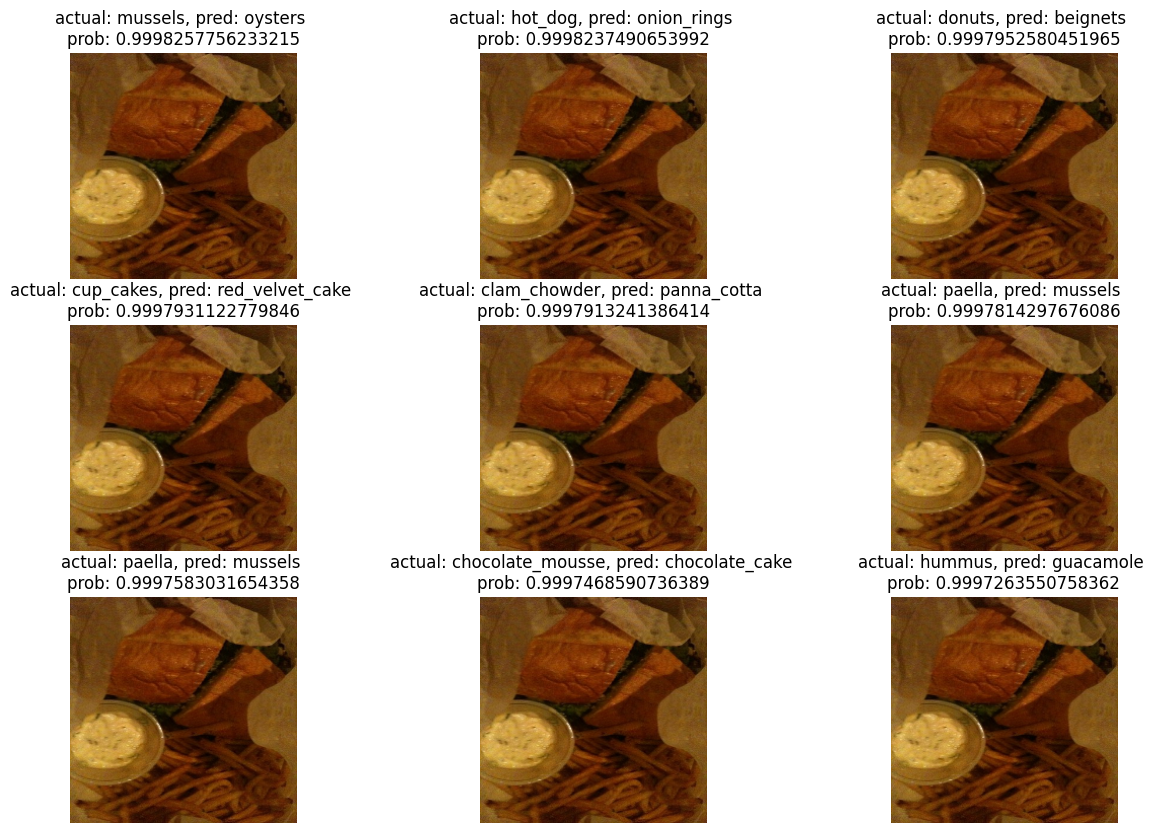

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred
images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)
